
# **Classifying Insurance Claim Status using CART and Random Forest Alogorithm**

- Submitted by : Sayan De
- Roll No : FT252082

In [ ]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
from sklearn.model_selection import GridSearchCV

**Objective**:  

- The goal of this project is to develop a predictive model to determine the likelihood of insurance claims for a tour insurance firm. By analyzing historical data, the project aims to identify key factors influencing claim frequency and compare the performance of CART and Random Forest algorithms in predicting claim outcomes.  

- Additionally, the project seeks to provide actionable business insights and strategic recommendations to the management to reduce claim frequency, optimize operations, and enhance decision-making.

In [ ]:
data = pd.read_csv('/content/insurance_part2_data.csv')

## Meta Data:
1. Target: Claim Status (Claimed)
2. Code of tour firm (Agency_Code)
3. Type of tour insurance firms (Type)
4. Distribution channel of tour insurance agencies (Channel)
5. Name of the tour insurance products (Product)
6. Duration of the tour (Duration in days)
7. Destination of the tour (Destination)
8. Amount worth of sales per customer in procuring tour insurance policies in rupees (in 100’s)
9. The commission received for tour insurance firm (Commission is in percentage of sales)
10. Age of insured (Age)


In [ ]:
# Basic information and initial checks
data.head()

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,C2B,Airlines,No,0.70,Online,7,2.51,Customised Plan,ASIA
1,36,EPX,Travel Agency,No,0.00,Online,34,20.00,Customised Plan,ASIA
2,39,CWT,Travel Agency,No,5.94,Online,3,9.90,Customised Plan,Americas
3,36,EPX,Travel Agency,No,0.00,Online,4,26.00,Cancellation Plan,ASIA
4,33,JZI,Airlines,No,6.30,Online,53,18.00,Bronze Plan,ASIA


In [ ]:
data.shape

(3000, 10)

Rows = 3000

Columns = 10

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           3000 non-null   int64  
 1   Agency_Code   3000 non-null   object 
 2   Type          3000 non-null   object 
 3   Claimed       3000 non-null   object 
 4   Commision     3000 non-null   float64
 5   Channel       3000 non-null   object 
 6   Duration      3000 non-null   int64  
 7   Sales         3000 non-null   float64
 8   Product Name  3000 non-null   object 
 9   Destination   3000 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 234.5+ KB


In [ ]:
data.isnull().sum()

,0
Age,0
Agency_Code,0
Type,0
Claimed,0
Commision,0
Channel,0
Duration,0
Sales,0
Product Name,0
Destination,0


There is no missing values so we can go ahead with EDA and build the CART and RF model

Cardinality Checking

In [ ]:
# Identify categorical columns
categorical_columns = ['Agency_Code', 'Type', 'Channel', 'Product Name', 'Destination']

# Check cardinality of categorical columns
for col in categorical_columns:
    unique_values = data[col].nunique()
    print(f"Column '{col}' has {unique_values} unique values.")

Column 'Agency_Code' has 4 unique values.
Column 'Type' has 2 unique values.
Column 'Channel' has 2 unique values.
Column 'Product Name' has 5 unique values.
Column 'Destination' has 3 unique values.


Since the categorical columns have relatively low cardinality (a maximum of 5 unique values), there is no immediate need to drop any of them

## Data Preprocessing

Upon investigation, we came across that the **Duration** Column has 3 entries with values -1 and 0 which in this context is invalid as the Tour duration should atleast be of 1 day

So, we would replace those values with the median of that group(Product Name)

We chose 'median' as its least impacted by Outliers

In [ ]:
invalid_duration_records = data[data['Duration'].isin([0, -1])]
invalid_duration_records

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
1508,25,JZI,Airlines,No,6.30,Online,-1,18.00,Bronze Plan,ASIA
1746,48,C2B,Airlines,No,0.14,Online,0,0.51,Customised Plan,ASIA
2628,37,C2B,Airlines,No,49.60,Online,0,124.00,Bronze Plan,ASIA


So, we would replace the 0 and -1 according to the Median duration for the Bronze and Customized Plan respectively

In [ ]:
# Group by 'Product Name' and calculate the median duration for each group
group_medians = data.groupby('Product Name')['Duration'].median()
group_medians

,Duration
Product Name,
Bronze Plan,18.0
Cancellation Plan,24.0
Customised Plan,27.0
Gold Plan,64.0
Silver Plan,90.0


So, we would replace the -1 duration record of the 'Bronze Plan' with the group median of 'Bronze plan' and similarly for the other 2 records

In [ ]:
# Replace invalid 'Duration' values (-1 and 0) with group-specific medians
for product, median in group_medians.items():
    data.loc[(data['Duration'].isin([0, -1])) & (data['Product Name'] == product), 'Duration'] = median

In [ ]:
invalid_duration_records = data[data['Duration'].isin([0, -1])]
invalid_duration_records

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination


The invalid values are now replaced with group medians

In [ ]:
# Split features (X) and target (y)
X = data.drop(columns=['Claimed'],axis = 1)
y = data['Claimed']

In [ ]:
data.describe()

,Age,Commision,Duration,Sales
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,38.091000,14.529203,70.022667,60.249913
std,10.463518,25.481455,134.043879,70.733954
min,8.000000,0.000000,1.000000,0.000000
25%,32.000000,0.000000,11.000000,20.000000
50%,36.000000,4.630000,27.000000,33.000000
75%,42.000000,17.235000,63.000000,69.000000
max,84.000000,210.210000,4580.000000,539.000000


## Observations

- The age group is relatively young, with an average age of 38.09 years old.
- There is a wide range of commission rates, with the lowest commission rate being 0% and the highest commission rate being 210.21%.
- The average duration is 70, but there is a wide range of durations, with the shortest lasting 1 minute and the longest lasting 4580
- The average sales amount is 60.2, but there is a fair amount of variability in the sales amounts, with the lowest sales amount being 0 and the highest sales amount being 539.

## Exploratory Data Analysis

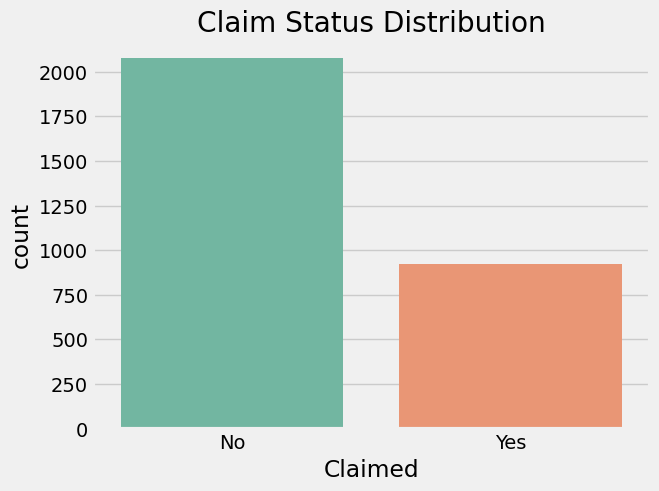

In [ ]:
sns.countplot(data=data, x='Claimed', palette='Set2')
plt.title('Claim Status Distribution')
plt.show()

In [ ]:
data['Claimed'].value_counts(normalize=True)

,proportion
Claimed,
No,0.692
Yes,0.308


As we Observe almost 70% of the people from our dataset did not claimed their insurance

So, there is a clear indication of Class Imbalance which is often natural in this kind of scenarios

## Univariate and Multivariate Analysis

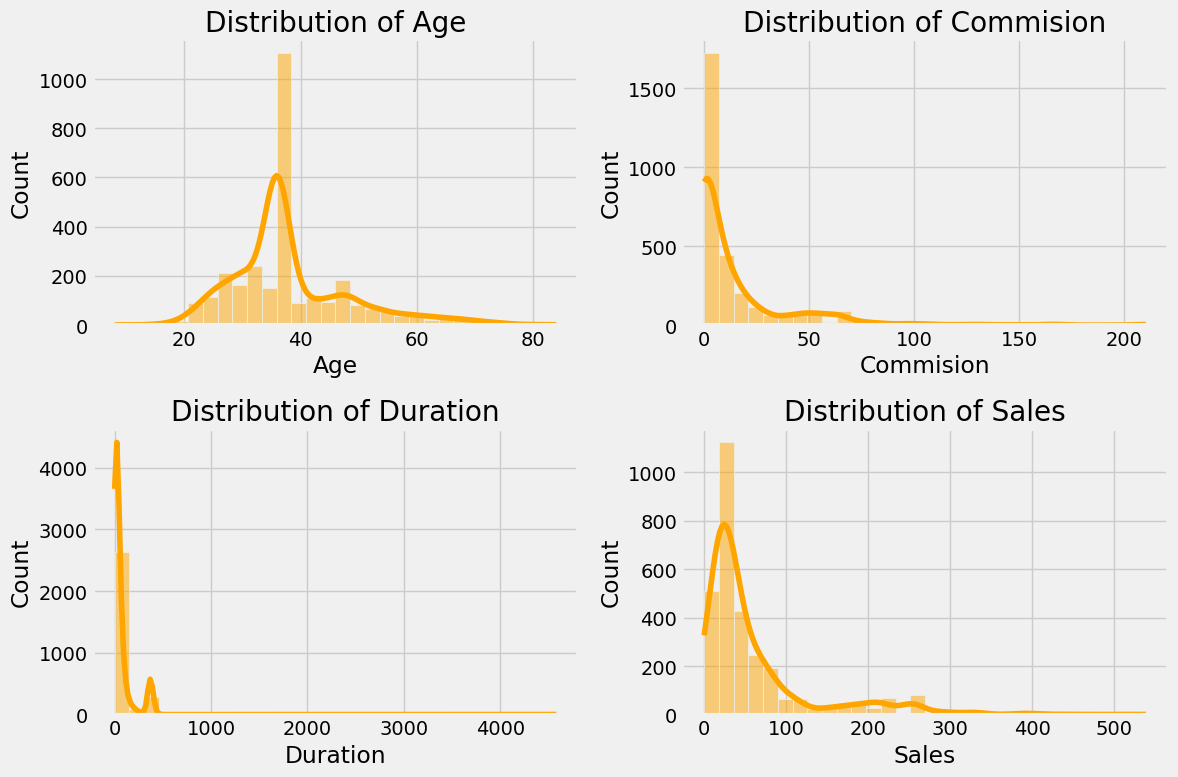

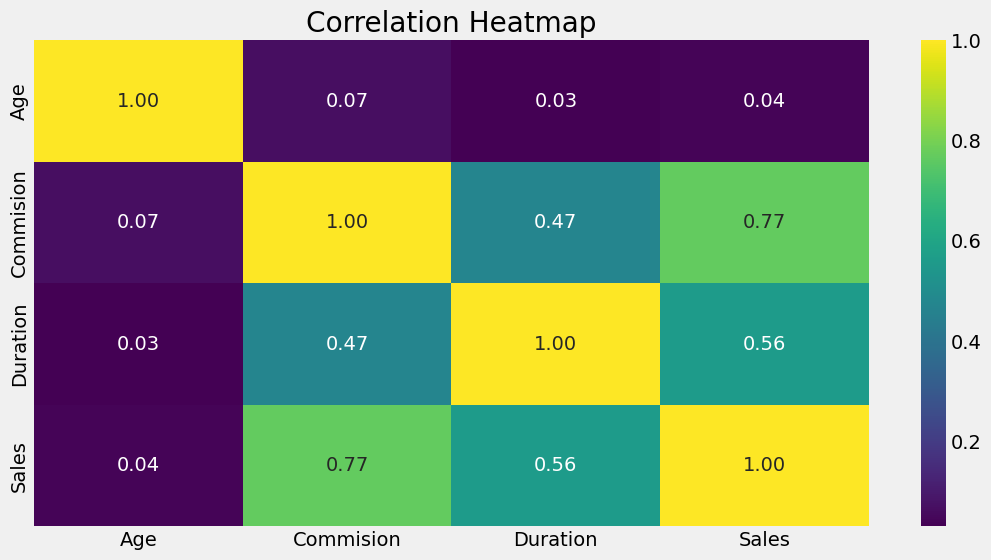

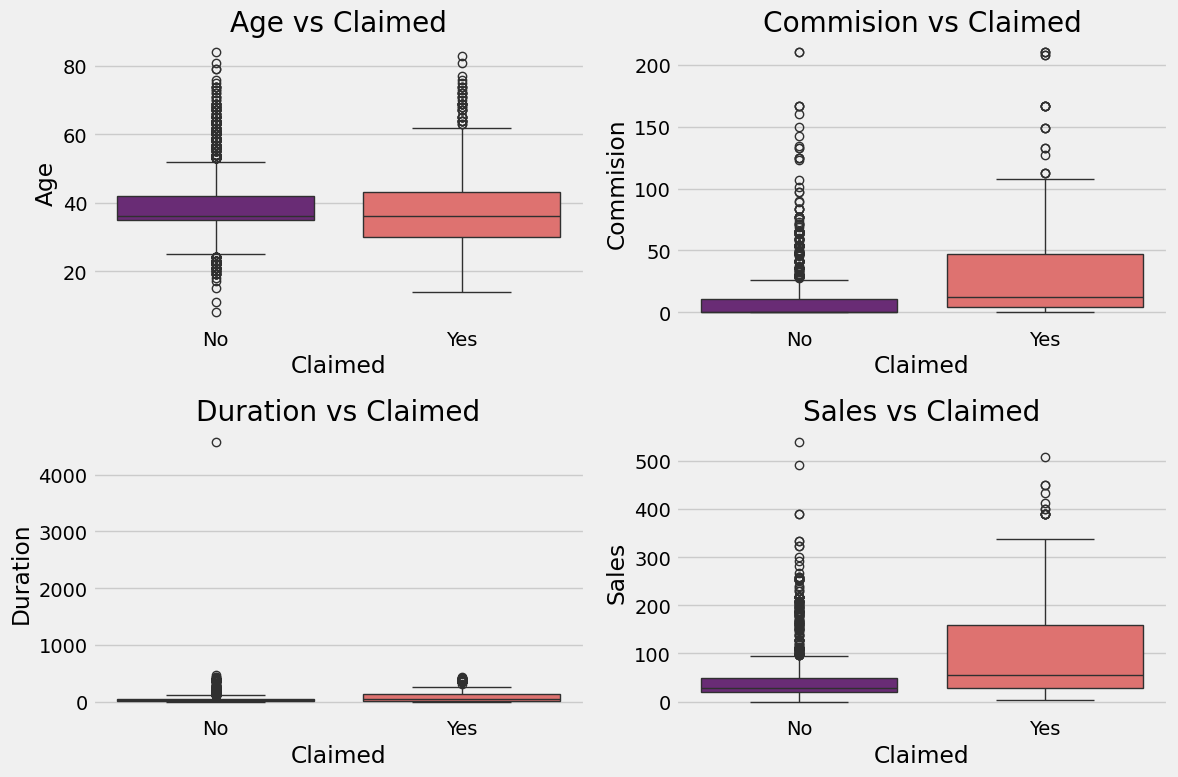

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograms
num_features = ['Age', 'Commision', 'Duration', 'Sales']
plt.figure(figsize=(12, 8))
for i, feature in enumerate(num_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data[feature], kde=True, bins=30, color='orange')
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 6))
correlation_matrix = data.corr(numeric_only = True)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="viridis")
plt.title("Correlation Heatmap")
plt.show()

# Boxplot
plt.figure(figsize=(12, 8))
for i, feature in enumerate(num_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=y, y=data[feature], palette='magma')
    plt.title(f'{feature} vs Claimed')
plt.tight_layout()
plt.show()


## Insights:

1. **Histogram**
- Sales and Commisson both are highly right skewed indicating very less people with very high amout of Sales and commission
- Age column is  having 2 peaks but the prominent one is at 38~39  

2. **Correlation Heatmap**
- there is a strong positive correlation(0.77) between Commission and Sales indicating with increasing Sales generated the commision also increases
- ALso between duration and Sales moderately positive correlation is being seen,which indicates the Sales increases as the Trip duration increases

3. **Box Plot**
- for Age, Commision and Sales the Claimed people have a larger Spread(range of values) indicating higher Variability
- the median for Commision and Sales is slightly higher for Claimed pepole than unclaimed peoples
- Also there are significant Outliers for Age , Commision and Sales

## **Distribution of Categorical variables wrt to Claim status**

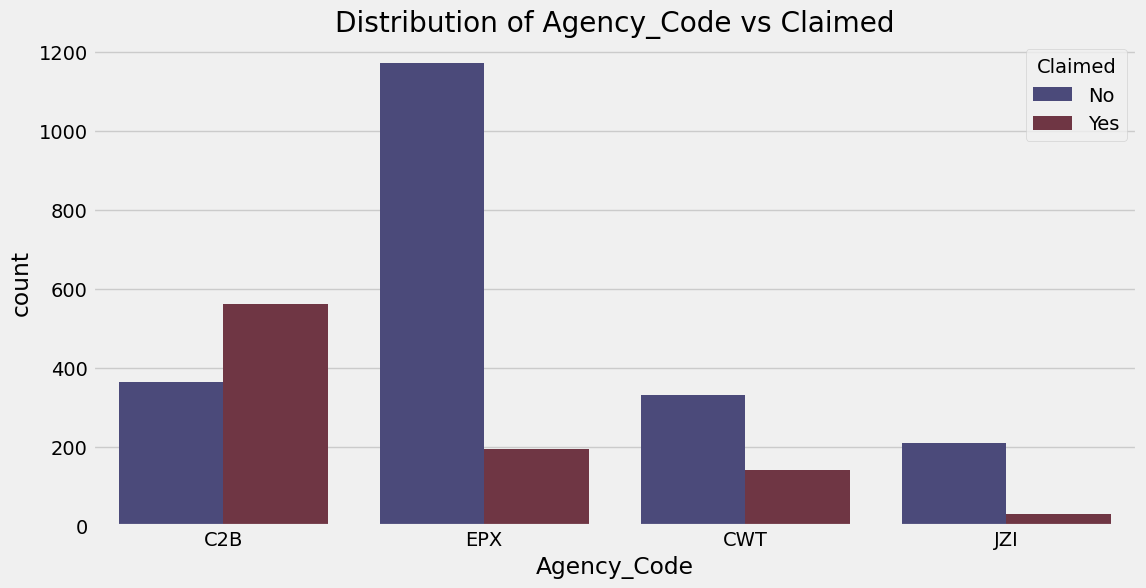

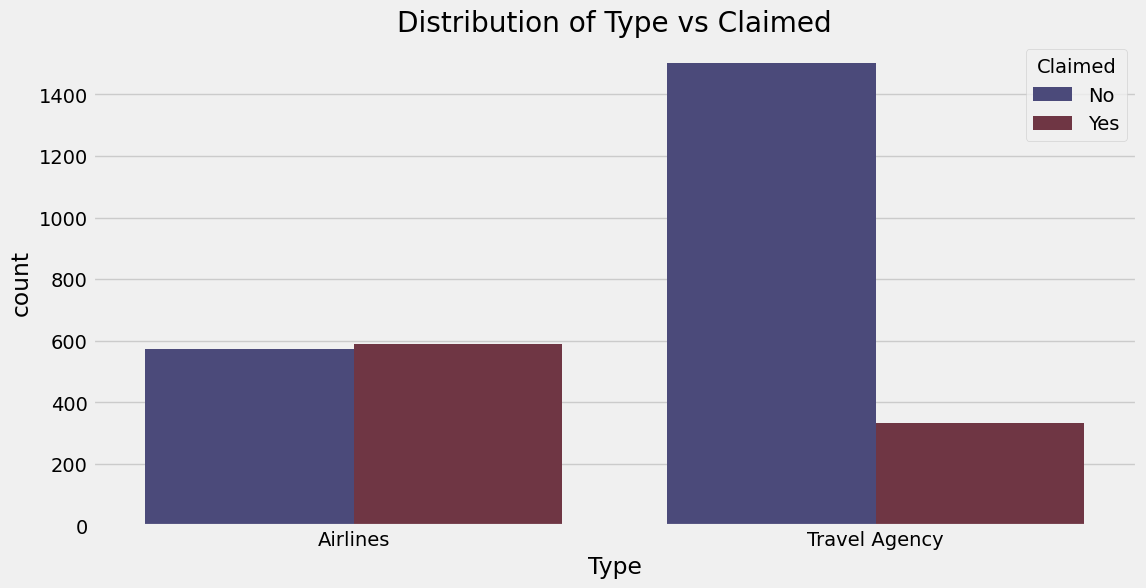

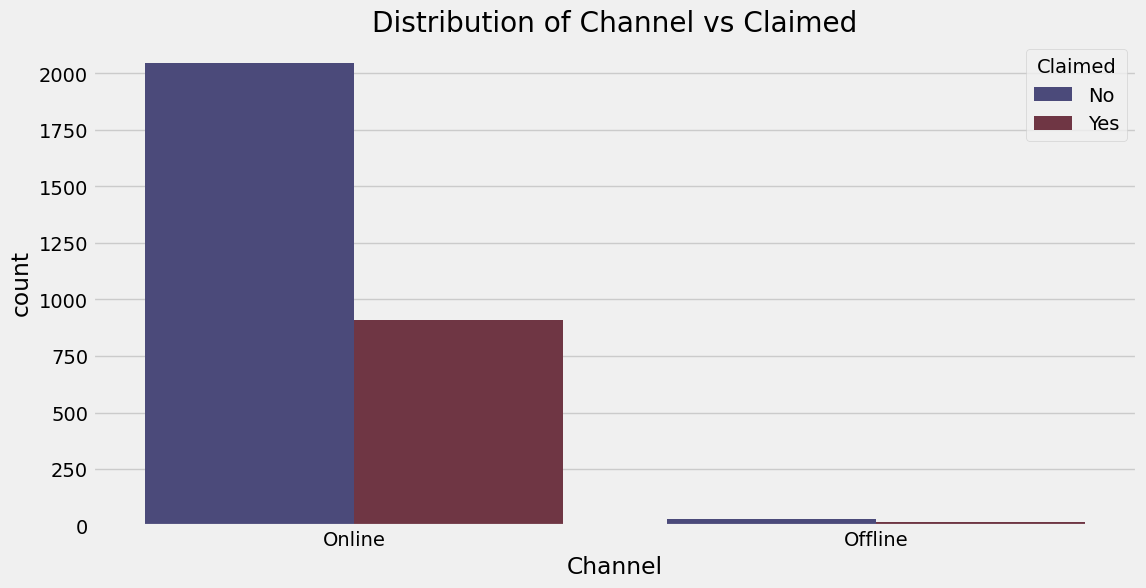

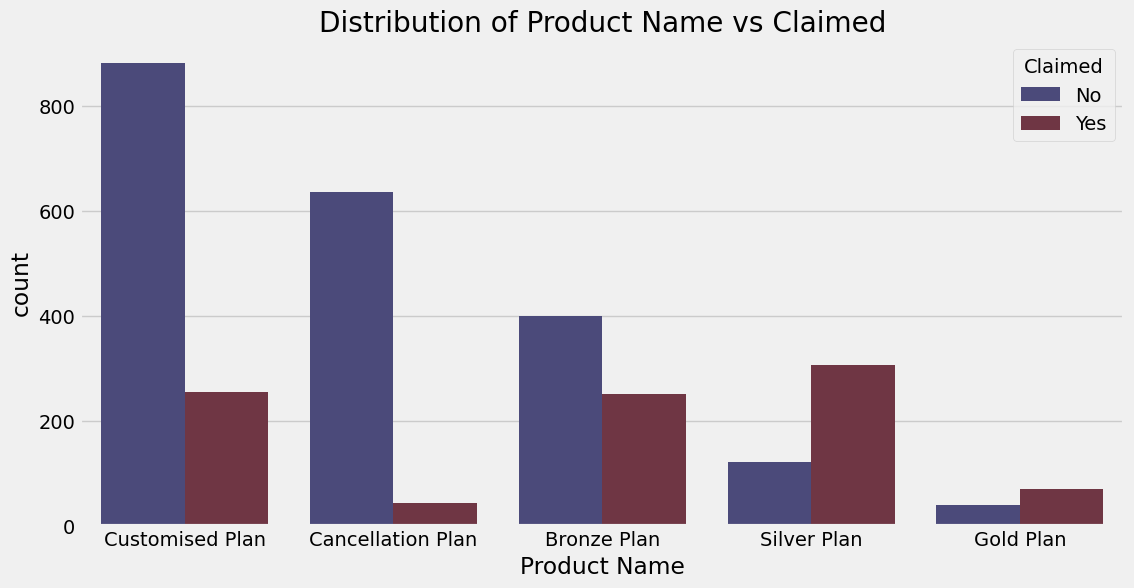

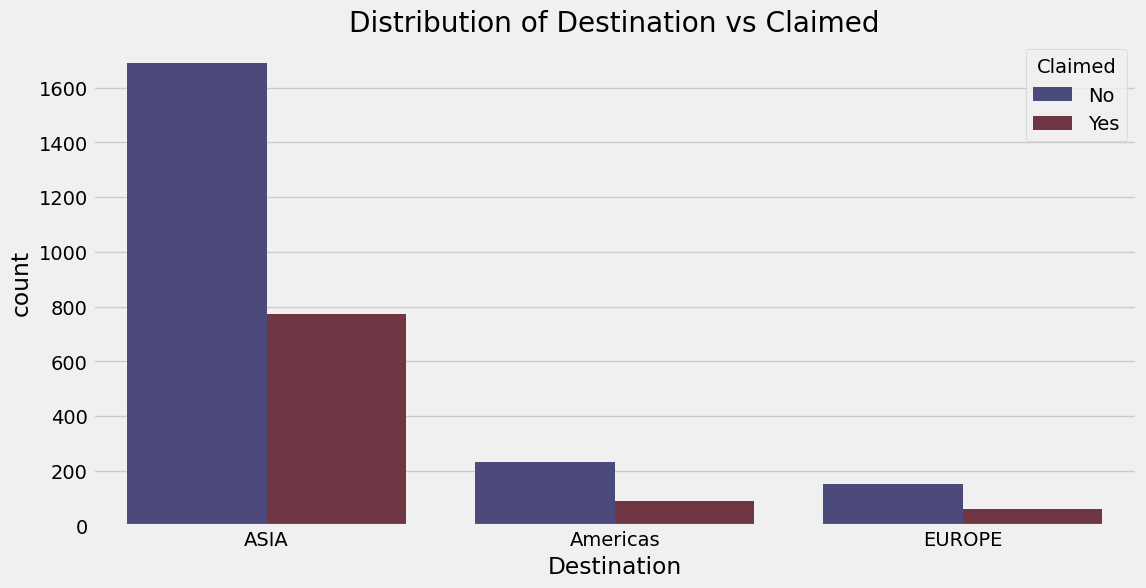

In [ ]:
for col in categorical_columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=data, x=col, hue='Claimed', palette='icefire')
    plt.title(f'Distribution of {col} vs Claimed')

## Observations :

1. Travel agency has high no of people who has not claimed their insurance
2. Almost 90% of insurance is done by online channel.
3. People mostly prefer Customized plan followed by Bronze and Silver plan
4. majority of the Insurance are from ASIA region
5. For Airlines the Claim status distribution(claimed and not claimed) is quite even

## Pair plot

<Figure size 1200x800 with 0 Axes>

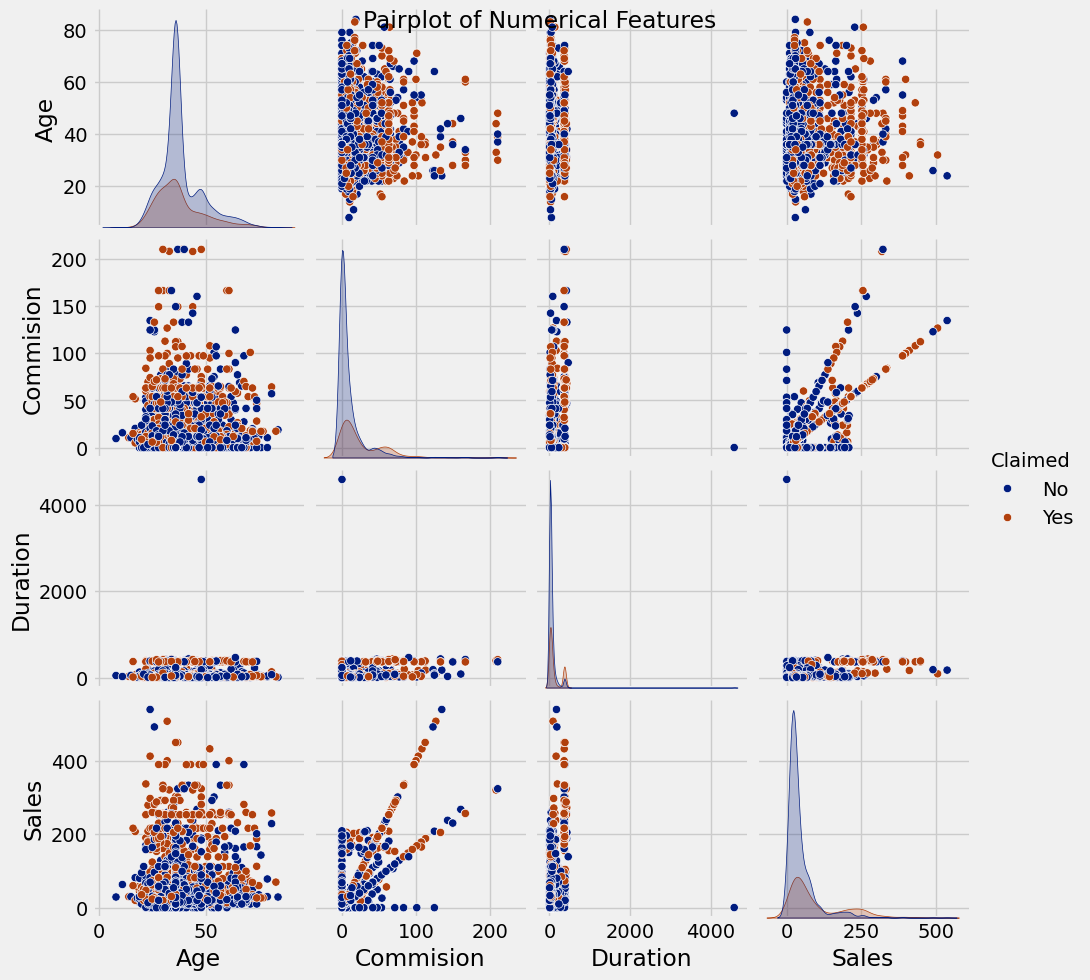

In [ ]:
plt.figure(figsize=(12, 8))
sns.pairplot(data, hue='Claimed', palette='dark')
plt.suptitle('Pairplot of Numerical Features')
plt.show()

## Observations & Insights

1. **Diagonal Analysis**
- From the distribution plots for Age, Commision and Sales we can see significant overlap between the 2 classes which indicates this are not very strong atrribute to segregate the 2 classes
- It means these may not work as a very good 'Predictdor variables'
2. **Off Diagonal Analysis**
- From the scatter plot for each pair we also can see that the 2 classes are not Linearly Seperable or there is no natural clsuters present in the dataset(which indicates model like Logistic Regression might find difficult to predict the classes, in this scenarios CART based algorithms(Axes paralell boundary algo) like Decision Tree and Random Forest are mostly favoured)
- The data points also formed Cloud like structure(excluding Commision and Sales) indicating there is no specific increasing or decreasing trend but for Commision and Sales we can observe a positive corelation

So, from the Pair Plot analysis we can draw the conclusion that the features might not have good predictive power to segregate the classes and hence we will be going for a Non Parametric algorithm(DT and RF) to build our Classification model


## Encoding categorical columns

In [ ]:
# Encode categorical variables with one-hot encoding

data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Encode target variable
data_encoded['Claimed'] = data_encoded['Claimed'].apply(lambda x: 1 if x == 'Yes' else 0)

# Verify preprocessing
data_encoded.head()

,Age,Claimed,Commision,Duration,Sales,Agency_Code_CWT,Agency_Code_EPX,Agency_Code_JZI,Type_Travel Agency,Channel_Online,Product Name_Cancellation Plan,Product Name_Customised Plan,Product Name_Gold Plan,Product Name_Silver Plan,Destination_Americas,Destination_EUROPE
0,48,0,0.70,7,2.51,False,False,False,False,True,False,True,False,False,False,False
1,36,0,0.00,34,20.00,False,True,False,True,True,False,True,False,False,False,False
2,39,0,5.94,3,9.90,True,False,False,True,True,False,True,False,False,True,False
3,36,0,0.00,4,26.00,False,True,False,True,True,True,False,False,False,False,False
4,33,0,6.30,53,18.00,False,False,True,False,True,False,False,False,False,False,False


The categorical columns -> 'Agency_Code', 'Type', 'Channel', 'Product Name', 'Destination'] are now converted into boolean TRUE or False so that the Model can understand.


In [ ]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             3000 non-null   int64  
 1   Claimed                         3000 non-null   int64  
 2   Commision                       3000 non-null   float64
 3   Duration                        3000 non-null   int64  
 4   Sales                           3000 non-null   float64
 5   Agency_Code_CWT                 3000 non-null   bool   
 6   Agency_Code_EPX                 3000 non-null   bool   
 7   Agency_Code_JZI                 3000 non-null   bool   
 8   Type_Travel Agency              3000 non-null   bool   
 9   Channel_Online                  3000 non-null   bool   
 10  Product Name_Cancellation Plan  3000 non-null   bool   
 11  Product Name_Customised Plan    3000 non-null   bool   
 12  Product Name_Gold Plan          30

So after encoding the categorical columns we have a total of 15 Predictor varaibles and 1 target column(Claimed)

## Splitting the Data into train test

We are splitting the data into 80% for training and 20% for testing/validating

In [ ]:
from sklearn.model_selection import train_test_split

# Split features (X) and target (y)
X = data_encoded.drop(columns=['Claimed'], axis = 1)
y = data_encoded['Claimed']

# Train-test split (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verify split
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")
print(f"Target distribution in train: {y_train.value_counts(normalize=True)}")
print(f"Target distribution in test: {y_test.value_counts(normalize=True)}")


Train size: (2400, 15), Test size: (600, 15)
Target distribution in train: Claimed
0    0.692083
1    0.307917
Name: proportion, dtype: float64
Target distribution in test: Claimed
0    0.691667
1    0.308333
Name: proportion, dtype: float64


## Buidling the Classification Model

## Hyperparameter Tuning with GridSearchCV

- We are using GridSearchCV to find the Optimal set of Hyperparameters
- We have choose the values keeping some heuristic assumptions like
1% to 3% of the data should be the 'min_samples_split' and one third times the 'min_samples_split' should be 'min_samples_leaf.
we have 2400 records in our training set so 1% of that comes at 24.

In [ ]:
# Parameter grid for Decision Tree
dt_param_grid = {
    'max_depth': [3, 5, 10, None],               # max depth of the tree
    'min_samples_split': [24, 30, 40],           # min number of samples required to split a node
    'min_samples_leaf': [8, 10, 15],             # min number of samples required in each leaf
    'criterion': ['gini', 'entropy'],           # criterion for splitting nodes
}

# Parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 150],             # number of trees in the forest
    'max_depth': [3, 5, 10, None],              # max depth of the trees
    'min_samples_split': [24, 30, 40],           # min number of samples required to split a node
    'min_samples_leaf': [8, 10, 15],             # min number of samples required in each leaf
    'bootstrap': [True, False]                  # whether bootstrap sampling is used
}


## Applying GridSearchCV with 5 fold CrossValidation

We are dividing the dataset into 5 folds to geta overall accuracy metrics along with the GridSearchCV implementation

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV for Decision Tree
dt_grid_search = GridSearchCV(estimator=dt_model, param_grid=dt_param_grid,
                              cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the GridSearch to the data
dt_grid_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best Parameters for Decision Tree:", dt_grid_search.best_params_)
print("Best Score for Decision Tree:", dt_grid_search.best_score_)

# Get the best model
best_dt_model = dt_grid_search.best_estimator_

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV for Random Forest
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid,
                              cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the GridSearch to the data
rf_grid_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best Parameters for Random Forest:", rf_grid_search.best_params_)
print("Best Score for Random Forest:", rf_grid_search.best_score_)

# Get the best model
best_rf_model = rf_grid_search.best_estimator_


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 24}
Best Score for Decision Tree: 0.7691666666666667
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters for Random Forest: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 15, 'min_samples_split': 40, 'n_estimators': 50}
Best Score for Random Forest: 0.7820833333333332


For the GridSearch the Primary metric that we are focusing on is **'Accuracy'**

Best parameters for Decision Tree : {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 24}

Best parameters for random forest : {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 15, 'min_samples_split': 40, 'n_estimators': 50}

## Final Model(with tuned parameters)

Decision Tree Model Performance:
Training Accuracy: 0.7808333333333334
Test Accuracy: 0.775
Confusion Matrix (Test):
 [[378  37]
 [ 98  87]]
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.79      0.91      0.85       415
           1       0.70      0.47      0.56       185

    accuracy                           0.78       600
   macro avg       0.75      0.69      0.71       600
weighted avg       0.77      0.78      0.76       600



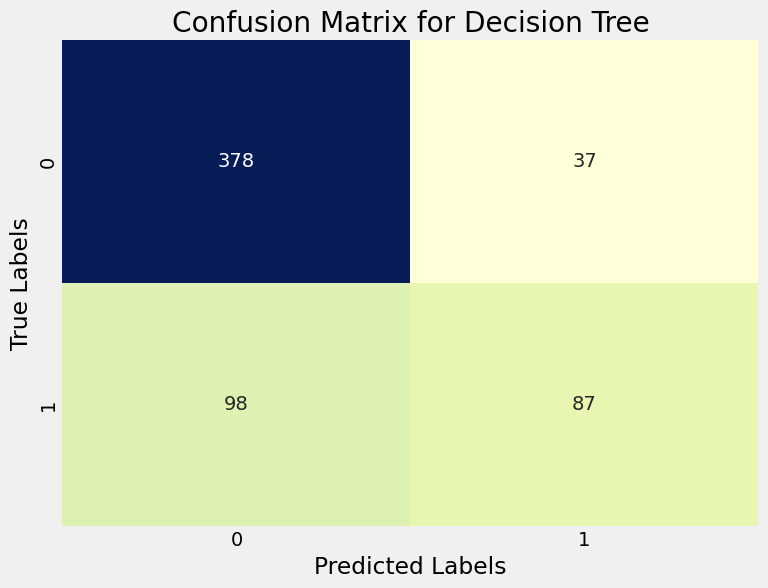

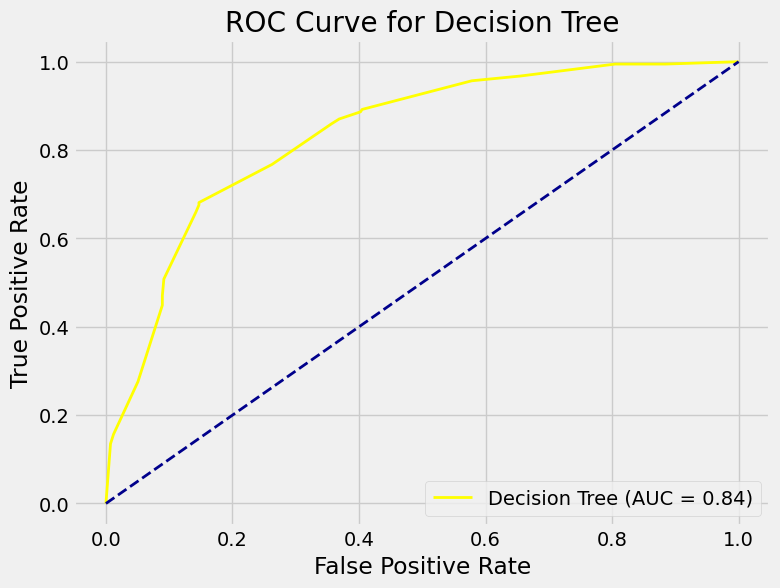


Random Forest Model Performance:
Training Accuracy: 0.8033333333333333
Test Accuracy: 0.79
Confusion Matrix (Test):
 [[372  43]
 [ 83 102]]
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.82      0.90      0.86       415
           1       0.70      0.55      0.62       185

    accuracy                           0.79       600
   macro avg       0.76      0.72      0.74       600
weighted avg       0.78      0.79      0.78       600



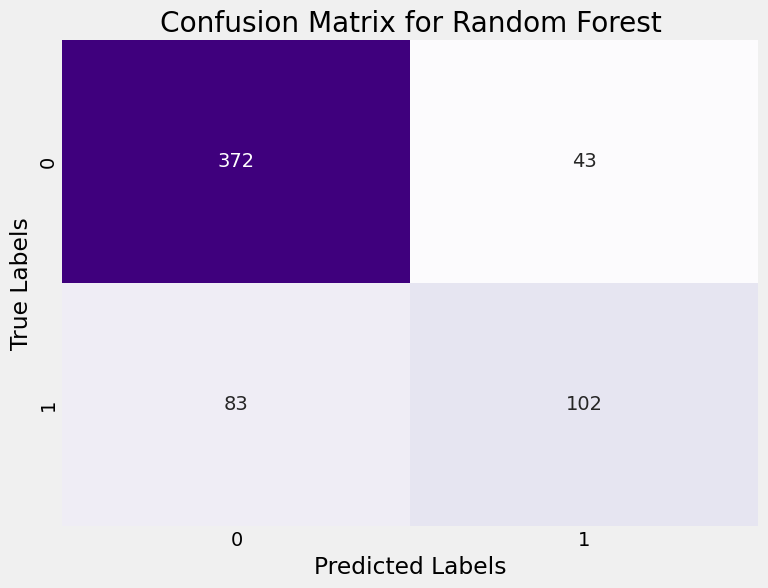

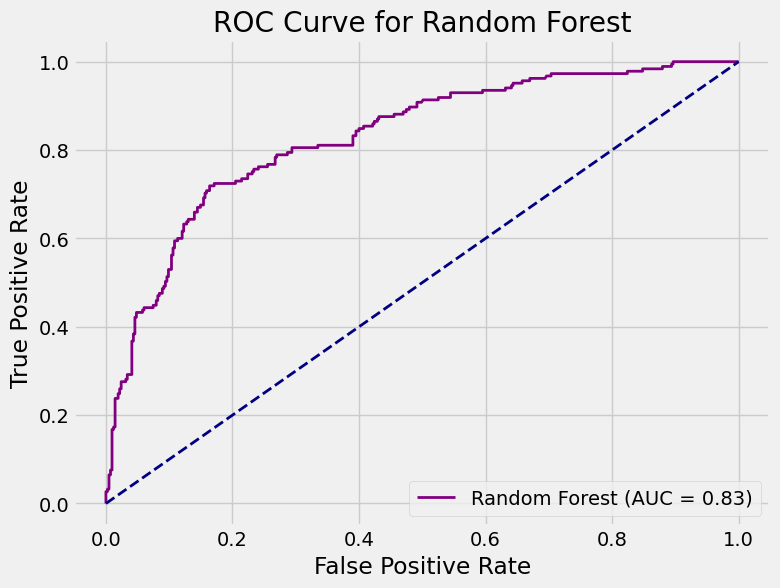

In [ ]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

# Initialize the final Decision Tree model with best parameters
final_dt_model = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=5,
    min_samples_leaf=10,
    min_samples_split=24,
    random_state=42
)

# Fit the model on the training data
final_dt_model.fit(X_train, y_train)

# Make predictions on the training set and test set
train_predictions_dt = final_dt_model.predict(X_train)
test_predictions_dt = final_dt_model.predict(X_test)

# Evaluate the Decision Tree model
print("Decision Tree Model Performance:")
print("Training Accuracy:", accuracy_score(y_train, train_predictions_dt))
print("Test Accuracy:", accuracy_score(y_test, test_predictions_dt))
print("Confusion Matrix (Test):\n", confusion_matrix(y_test, test_predictions_dt))
print("Classification Report (Test):\n", classification_report(y_test, test_predictions_dt))

# Plot Confusion Matrix for Decision Tree
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, test_predictions_dt), annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title("Confusion Matrix for Decision Tree")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Plot ROC curve for Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, final_dt_model.predict_proba(X_test)[:, 1])
roc_auc_dt = auc(fpr_dt, tpr_dt)
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='yellow', lw=2, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')
plt.plot([0, 1], [0, 1], color='darkblue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree')
plt.legend(loc="lower right")
plt.show()

# Initialize the final Random Forest model with best parameters
final_rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    min_samples_leaf=15,
    min_samples_split=40,
    bootstrap=False,
    random_state=42
)

# Fit the model on the training data
final_rf_model.fit(X_train, y_train)

# Make predictions on the training set and test set
train_predictions_rf = final_rf_model.predict(X_train)
test_predictions_rf = final_rf_model.predict(X_test)

# Evaluate the Random Forest model
print("\nRandom Forest Model Performance:")
print("Training Accuracy:", accuracy_score(y_train, train_predictions_rf))
print("Test Accuracy:", accuracy_score(y_test, test_predictions_rf))
print("Confusion Matrix (Test):\n", confusion_matrix(y_test, test_predictions_rf))
print("Classification Report (Test):\n", classification_report(y_test, test_predictions_rf))

# Plot Confusion Matrix for Random Forest
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, test_predictions_rf), annot=True, fmt="d", cmap="Purples", cbar=False)
plt.title("Confusion Matrix for Random Forest")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Plot ROC curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, final_rf_model.predict_proba(X_test)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='purple', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.legend(loc="lower right")
plt.show()


## Observation and Insights
### Comparison of Models
| Metric                | Decision Tree   | Random Forest |
|-----------------------|----------------|---------------|
| Training Accuracy     | 78.08%         | **80.33%**    |
| Test Accuracy         | 77.50%         | **79.00%**    |
| Recall (Class `0`)    | **91%**        | 90%           |
| Recall (Class `1`)    | 47%            | **55%**       |
| Precision (Class `1`) | 70%            | **70%**       |
| F1-Score (Class `1`)  | 56%            | **62%**       |
| AUC (ROC Curve)       | Lower          | **Higher**    |

---

### Recommendation
  Based on the analysis:
  - **Random Forest** is the better model because:
    - It achieves higher test accuracy and training accuracy.
    - It provides a better balance between precision and recall for class `1`.
    - It has a higher F1-score for positive cases, meaning better handling of imbalanced data.
    - Its ROC curve indicates superior overall classification performance.

  Thus, **Random Forest** is recommended for this Classification task

## Feature Importance

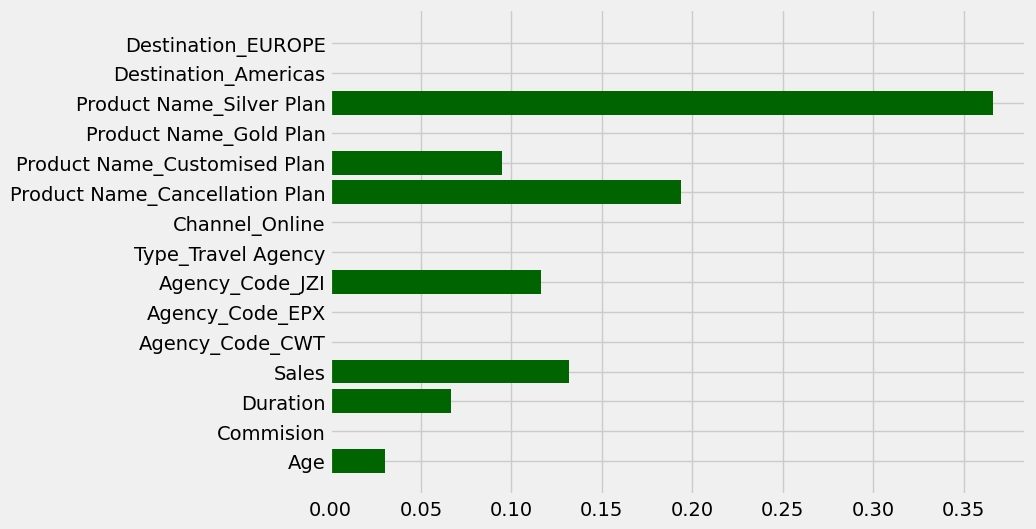

In [ ]:
plt.figure(figsize=(8,6))
plt.barh( [col for col in X_train.columns] ,final_dt_model.feature_importances_, color = 'darkgreen')
plt.show()

## Observation

1. As we can observe The Product Name(The Tour Plans) feature carrying the Highest feature importance according to Decision Tree

2. Whereas as Fetaures like Channel , Commision played negligible imoprtance in predicting the Class

<BarContainer object of 15 artists>

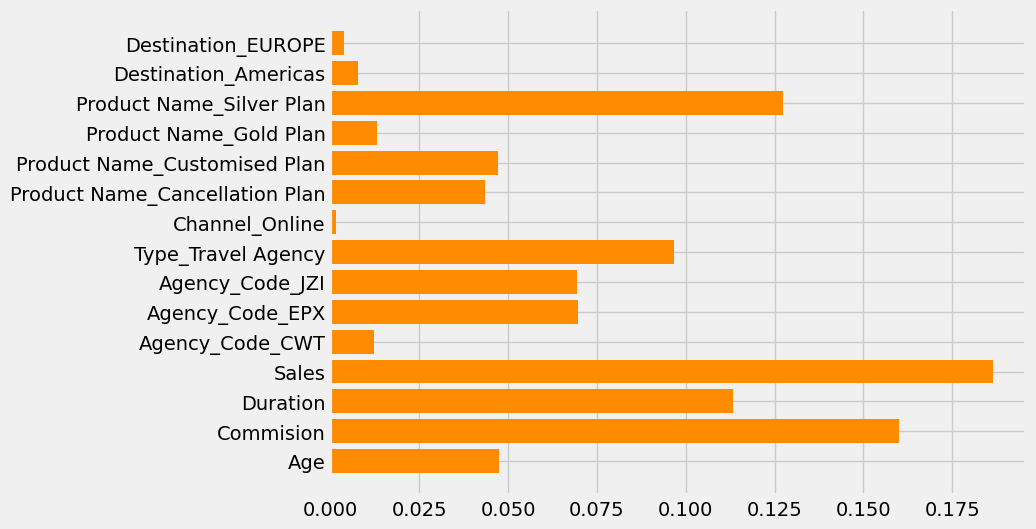

In [ ]:
plt.figure(figsize=(8,6))
plt.barh( [col for col in X_train.columns] ,final_rf_model.feature_importances_, color = 'darkorange')

## Obsservation

1. But According to Random Forest model , Sales played Highest Feature importance followed by Commision and then Product Name

2. For Random Forest, Sales, Commsion, product name and Duration are the Top 4 features

So, from both the Feature Importance Bar graphs we can conclude that -

- The Tour Plan(Bronze/Silver/Gold/Customized etc) played a crucial factor determining the Claim Status

## **Key Insights**

1. The RF model has better accuracy, precsion, recall, f1 score better than other two CART & NN
2. Other models & ensemble techniques can be used to improve the model performance as these models are not good enough
3. As per the data 90% of insurance is done by online channel. Streamlining online experiences benefitted customers, leading to an increase in conversions, which subsequently raised profits.
5. More sales happen via Agency than Airlines. The trend shows the claim are processed more at Airline.


## Recommendations:
1.	**Product Portfolio optimization** – Since majority of customers prefer customized plans, consider enhancing the product offering to retain customers effectively.
2.	**Regional and Demographic targeting** - The majority of insurance policies originate from the Asia region. Introduce region-specific products or promotional campaigns to attract regional customers.
3.	**Channel Optimization** - With almost 90% of sales through online channels, continue investing in digital platforms to improve user experience.
